In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
import etpof
from tqdm import tqdm

In [2]:
res_avg = np.mean([4.88918152, 4.88946346])
res_std = np.mean([0.00183618, 0.00167924])

In [3]:
imgs, files = etpof.read_image_series('PTV', 'a')

100%|██████████| 200/200 [00:00<00:00, 237.39it/s]


In [4]:
def remove_background(img, sigma_color1 = 50, sigma_space1 = 9,
                      sigma_color2 = 20, sigma_space2 = 3, noise_threshold=50):
    
    # TODO: Explain that masking might have been easier
    
    # # If the image has three channels, convert it to grayscale
    # if len(img.shape) == 3:
    #     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Apply a bilateral filter to TODO: explain how the bilateral filter works
    img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=sigma_color1, sigmaSpace=sigma_space1)
    
    # Apply another bilateral filter for finer detail removal
    img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=sigma_color2, sigmaSpace=sigma_space2)

    # Set all pixels below a certain threshold to zero with a to-zero threshold
    _, img_proc = cv.threshold(img_proc, noise_threshold, 255, cv.THRESH_TOZERO)

    # Perform a hit-or-miss transform on a binary version to remove all pixels with 
    # only black neighbours on all sides
    hitmiss_kernel = np.int8([[0,  -1,  0],
                              [-1, +1, -1],
                              [0,  -1,  0]])
    img_binary = cv.threshold(img_proc, 0, 255, cv.THRESH_BINARY)[1]
    img_singles = cv.morphologyEx(img_binary, cv.MORPH_HITMISS, hitmiss_kernel)
    img_proc[img_singles == 255] = 0

    return img_proc

100%|██████████| 200/200 [00:02<00:00, 71.76it/s]


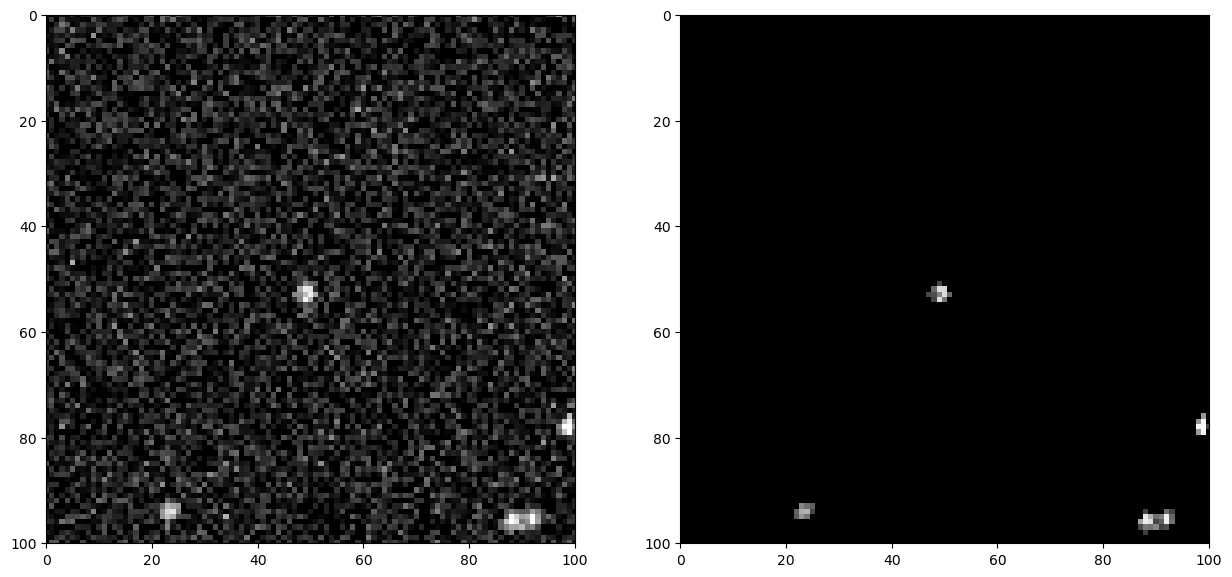

In [5]:
imgs_nobg = [remove_background(img) for img in tqdm(imgs)]

# Show the image and the processed image next to each other
fig, ax = plt.subplots(1,2, figsize = (15, 15))
ax[0].imshow(imgs[0], cmap = 'gray')
ax[1].imshow(imgs_nobg[0], cmap = 'gray')
ax[0].set_xlim(0, 100); ax[0].set_ylim(100, 0)
ax[1].set_xlim(0, 100); ax[1].set_ylim(100, 0)
plt.show()

In [12]:
# # Draw the contours with random colours
# img_cnt = img_rgb.copy()
# for cnt in cnts:
#     color = np.random.randint(85, 255, 3, dtype=np.uint8)
#     img_cnt = cv.drawContours(img_cnt, cnt, -1, 
#                                (int(color[0]), int(color[1]), int(color[2])), 2)

In [265]:
# def gaussian_peak

def find_local_max(idx, img):
    # Perform a small Gaussian blur on the region
    img = cv.GaussianBlur(img, (3, 3), 0,
                                   borderType=cv.BORDER_CONSTANT)

    # Maximum filter on this (processed) region
    img_max = ndimage.maximum_filter(img, size=3)
    
    # Filter out maxima of 0 at the edges
    img_max = np.where(img_max == 0, -1, img_max)
    
    # Get indices
    idx_max = idx[:, img == img_max]
    
    return idx_max, img_max

def destroy_neighbors(img, idx, idx_max, neighbor_pixel=1.5):
    
    # While there is more than one maximum...
    if idx_max.shape[1] > 1:
        print('Multiple maxima detected')
        
        # Check the Euclidian distances between the maxima
        dists = etpof.all_distances(idx_max[0,:], idx_max[1,:])
        
        # If each column contains a nonzero value smaller than neighbor distance
        if np.all(np.any(np.logical_and(dists < neighbor_pixel, 
                                        dists != 0), axis=0)):
            print('All maxima are neighbors')

            # # Perform a small Gaussian blur on the box
            img_blur = cv.GaussianBlur(img, (3, 3), 0,
                                           borderType=cv.BORDER_CONSTANT)
        
            # Get the new local maxima
            idx_max, int_max = find_local_max(idx, img_blur)
            
        # If they are not neighbours
        else:
            print('Multiple clusters detected')

            # Separate the list of maxima into neighbors
            
            # Run this function again on the separate groups
            
            
    
    # If no maxima were detected
    elif idx_max.shape[1] == 0:
        # Raise an exception
        raise ValueError('No maxima detected')
    
    return idx_max

def find_particle_center(img, img_nobg, cnts, cnt_idx, neighbor_pixel=1.5):
    
    cnt = cnts[cnt_idx]
    
    # Get the bounding box of the contour
    box_x, box_z, box_w, box_h = cv.boundingRect(cnt)
    
    # Get the intensities of the pixels in the bounding box + margin as a 2D array
    box_marg = 2
    box_int = (img[(box_z - box_marg):(box_z + box_h + box_marg),
                    (box_x - box_marg):(box_x + box_w + box_marg)]
                    .reshape(box_h + 2 * box_marg, box_w + 2 * box_marg))
    box_int_proc = (img_nobg[(box_z - box_marg):(box_z + box_h + box_marg),
                    (box_x - box_marg):(box_x + box_w + box_marg)]
                    .reshape(box_h + 2 * box_marg, box_w + 2 * box_marg))
       
    # TODO: Set pixels that are on another contour to zero
    # cnts_other = [c for c in cnts if c is not cnt]
    # mask = np.zeros_like(box_int)
    # mask = cv.drawContours(mask, cnts[4], -1, 255, -1)
    # box_int = np.where(mask != 255, box_int, 0)
    
    # Get the image coordinates corresponding to each of these pixels
    box_idx = np.indices((box_h + 2 * box_marg, box_w + 2 * box_marg))
    
    # Get the local maxima in the region
    box_idx_max, box_int_max = find_local_max(box_idx, box_int_proc)
    print(box_idx_max)
    
    
    # TODO: Always Gaussian blur to find maximum
    
    # # Plot the unprocessed box and center pixel(s)
    # fig, ax = plt.subplots()
    # ax.imshow(box_int, cmap = 'gray')
    # ax.scatter(*np.flipud(box_idx_max), c ='r', s = 20, marker = 's')
    # plt.show()
    
    # Deal with any neighboring maxima
    box_idx_max = destroy_neighbors(box_int_proc, box_idx, box_idx_max)
    
    # print(box_idx_max[0,:], box_idx_max[1,:])
    
    # Get the real x and z coordinates
    box_px = box_idx + np.array([box_z - box_marg, box_x - box_marg])[:, None, None]
    box_px_max = box_idx_max + np.array([box_z - box_marg, box_x - box_marg])[:, None]        

    # SUBPIXEL DETECTION
    # When only one maximum was detected, the entire region can be used to fit a 
    # Gaussian in two directions
    
    # Use curve_fit to fit a Gaussian to the region
    def gaussian(x, a, x0, sigma):
        return a * np.exp(-((x - x0)**2) / (2 * sigma**2))
    
    # Get slices around box_idx_max in the x and z direction
    row_px = box_px[1, box_idx_max[0], :].flatten()
    col_px = box_px[0, :, box_idx_max[1]].flatten()
    
    row_int = box_int[box_idx_max[0], :].flatten()
    col_int = box_int[:, box_idx_max[1]].flatten()
    
    # Initial parameters
    # TODO: Change sigma to number of pixels that are at maximum
    a = box_int[*box_idx_max][0]
    x0 = box_px_max[1][0]
    z0 = box_px_max[0][0]
    sigma_x = 1
    sigma_z = 1
    
    
    popt_row, _ = curve_fit(gaussian, row_px, row_int, p0=[a, x0, sigma_x])
    popt_col, _ = curve_fit(gaussian, col_px, col_int, p0=[a, z0, sigma_z])
    
    # Get the coordinates of the maximum of the Gaussian
    x_max = popt_row[1]
    z_max = popt_col[1]
    
    # Plot the unprocessed box, maximum pixels and particle center
    fig, ax = plt.subplots()
    ax.imshow(img, cmap = 'gray')
    ax.invert_yaxis()
    ax.set_xlim(box_x - box_marg - 0.5, box_x + box_w + box_marg + 0.5)
    ax.set_ylim(box_z + box_h + box_marg + 0.5, box_z - box_marg - 0.5)
    ax.scatter(*np.flipud(box_px_max), c ='r', s = 20, marker = 's')
    ax.scatter(x_max, z_max, c = 'r', s = 100, marker = '+')
    plt.show()
    
    return x_max, z_max

# def detect_particles(img, img_nobg):

# Todo: FOR LOOP!

cnt_idx = 32 # 32 double, 3 multipixel max, 1 single max

img_nobg = imgs_nobg[cnt_idx]
img = imgs[cnt_idx]

# Find the contours in the background-less image
cnts, _ = cv.findContours(img_nobg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter out contours that are too small
cnts = [cnt for cnt in cnts if cv.contourArea(cnt) > 1]

# for cnt in cnts:

x_max, z_max = find_particle_center(img, img_nobg, cnts, cnt_idx)

[[3 4]
 [3 7]]
Multiple maxima detected
Multiple clusters detected


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [209]:
test_x = np.array([7, 1, 2, 8, 3])
test_z = np.array([5, 1, 1, 5, 1])
np.logical_and(etpof.all_distances(test_x, test_z) > 0, etpof.all_distances(test_x, test_z) < 2)

# Get groups that satisfy the condition
np.where(np.logical_and(etpof.all_distances(test_x, test_z) > 0, etpof.all_distances(test_x, test_z) < 2))

(array([0, 1, 2, 2, 3, 4]), array([3, 2, 1, 4, 0, 2]))

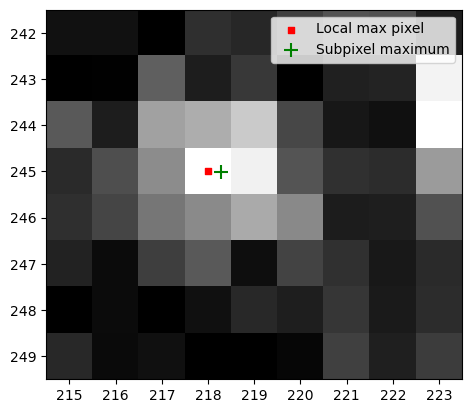

In [84]:
# # Get all pixels enclosed by the contour
# mask = np.zeros_like(img_proc)
# mask = cv.drawContours(mask, [cnt], -1, 255, -1)
# 
# # Get the x and z coordinates and intensities of the pixels
# cnt_coords = np.array(np.where(mask == 255))
# # box_int = img[np.where(mask == 255)]

# # Get 2D local maxima in this blob
# peaks, _ = find_peaks(box_int, distance=5, prominence=5)


# Show this contour on the original image
fig, ax = plt.subplots()
ax.imshow(img, cmap = 'gray')
ax.set_xlim(x - box_marg - 0.5, x + w + box_marg + 0.5)
ax.set_ylim(z + h + box_marg + 0.5, z - box_marg - 0.5)

# Scatter plot of peaks
ax.scatter(*np.flipud(box_px_max), c ='r', s = 20, marker = 's',
           label = 'Local max pixel')
ax.scatter(x_max, z_max, c = 'g', s = 100, marker = '+',
           label = 'Subpixel maximum')
plt.legend()
plt.show()



In [ ]:
# Simple blob detection
detector = cv.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(img_proc)

# Draw detected blobs as red circles.
# cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
img_with_keypoints = cv.drawKeypoints(img_proc, keypoints, np.array([]), 
                                      (0, 255, 0),
                                      cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
fig, ax = plt.subplots(1,1, figsize = (15, 15))

ax.imshow(img_with_keypoints, cmap = 'gray')
ax.set_xlim(roi[2], roi[3])
ax.set_ylim(roi[0], roi[1])
plt.show()
